## Eval Module

In [161]:
import pandas as pd
import sqlalchemy
import os, sys, copy, random, pickle, cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append("../")

%load_ext autoreload
%autoreload 2

from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.Interproc import DBInterface, GuiviewState

from modules.AnalysisHelpers import ( multiPlot, colorCube,
         SubprocColorCube, subprocColorCube, buildConfusionData, 
         buildConfusionPlotData, buildRegionMarkers, confusionPlotByViews,
         confusionPlotByImage, PixelConfusionMatrix, cvtPlot,
         applyTracker, presetCubeViews, bytesToPic, bytesToPic2,
         croppedPic, colorInRange, imgToColors, pointsToList,
         roiSelectZoomWindow, roiSelectScoreWindow, subprocBatchOutput,
         exploreImgs, buildImgComparisonData, subprocEval)

from modules.EvalHelpers import EvalTracker, EvalDataset
import sqlalchemy
from modules.ControlEval import EvalFactory
from modules.DataSchemas import ScoreSchema

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Basic Import of guiview log output

In [167]:
engine = sqlalchemy.create_engine('sqlite:///../data/usr/eval_tmp.db')

In [168]:
# from outputOutcomeData
df_outcome = pd.read_sql_table('output_dataframe', con=engine)
df_outcome[:5]

,index,input_data0_0,input_data0_1,input_data0_2,input_data0_3,input_data1_0,input_data1_1,input_data1_2,input_data1_3,input_data2_0,...,track_data3_2,track_data3_3,track_obj_exists_0,track_obj_exists_1,track_obj_exists_2,track_obj_exists_3,track_obj_type_0,track_obj_type_1,track_obj_type_2,track_obj_type_3
0,0,107.0,111.0,None,None,214.0,218.0,None,None,54.0,...,None,None,True,None,None,None,circle,None,None,None
1,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,...,None,None,True,None,None,None,circle,None,None,None
2,2,NaN,NaN,None,None,NaN,NaN,None,None,NaN,...,None,None,True,None,None,None,circle,None,None,None
3,3,NaN,NaN,None,None,NaN,NaN,None,None,NaN,...,None,None,True,None,None,None,circle,None,None,None
4,4,NaN,NaN,None,None,NaN,NaN,None,None,NaN,...,None,None,True,None,None,None,circle,None,None,None


### Basic Filtering on Outcome Table

In [164]:
def filterObjCols(df, objEnum=0):
    obj_cols = filter(lambda sCol: sCol.find('_' + str(objEnum)) > -1, 
                     list(df.columns))
    return obj_cols

def filterInputScoreRows(df, objEnum=0):
    col_name = 'input_obj_exists_' + str(objEnum)
    filtered_rows = df[col_name] == True
    return filtered_rows

def displayRelevantTable(df, objEnum=0):
    ''' display only cols for requested obj-enum
        display only rows for frame with an input-score
    '''
    rows = filterInputScoreRows(df, objEnum)
    cols = filterObjCols(df, objEnum)
    return df[rows][cols]

displayRelevantTable(df_outcome)

,input_data0_0,input_data1_0,input_data2_0,input_data3_0,input_obj_exists_0,input_obj_type_0,track_data0_0,track_data1_0,track_data2_0,track_data3_0,track_obj_exists_0,track_obj_type_0
0,107.0,214.0,54.0,52.0,True,circle,101,210,64,64,True,circle
9,194.0,200.0,52.0,53.0,True,circle,183,199,66,66,True,circle
78,385.0,307.0,54.0,51.0,True,circle,382,302,54,54,True,circle
116,342.0,302.0,42.0,39.0,True,circle,337,301,44,44,True,circle
136,268.0,267.0,32.0,31.0,True,circle,263,266,35,35,True,circle
176,328.0,264.0,12.0,12.0,True,circle,323,263,13,13,True,circle
187,361.0,270.0,9.0,10.0,True,circle,357,267,10,10,True,circle
194,369.0,279.0,10.0,9.0,True,circle,365,279,7,7,True,circle
195,369.0,280.0,11.0,9.0,True,circle,367,280,8,8,True,circle
201,378.0,280.0,9.0,9.0,True,circle,376,281,4,4,True,circle


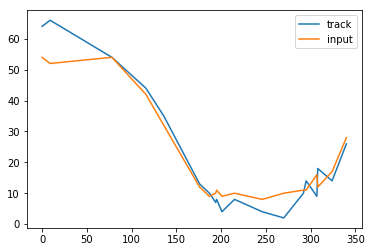

In [176]:
condensed = displayRelevantTable(df_outcome)
plt.plot(condensed.track_data2_0)
plt.plot(condensed.input_data2_0)
plt.legend(['track', 'input'])

### Analyze Column Types

In [128]:
series = df_outcome.input_obj_exists_0
print type(series)
print series.dtype

<class 'pandas.core.series.Series'>
object


In [129]:
series2 = df_outcome['input_data0_0']
series2.dtype

dtype('float64')

In [123]:
# what type of columns are present in df_outcome?
dtypes = []
for _col in df_outcome.columns:
    _val = None
    try:
        _val = df_outcome[_col].dtype
    except:
        pass
    dtypes.append((_col, _val))
    
dtypes

[('index', dtype('int64')),
 ('input_data0_0', dtype('float64')),
 ('input_data0_1', dtype('float64')),
 ('input_data0_2', dtype('O')),
 ('input_data0_3', dtype('O')),
 ('input_data1_0', dtype('float64')),
 ('input_data1_1', dtype('float64')),
 ('input_data1_2', dtype('O')),
 ('input_data1_3', dtype('O')),
 ('input_data2_0', dtype('float64')),
 ('input_data2_1', dtype('float64')),
 ('input_data2_2', dtype('O')),
 ('input_data2_3', dtype('O')),
 ('input_data3_0', dtype('float64')),
 ('input_data3_1', dtype('float64')),
 ('input_data3_2', dtype('O')),
 ('input_data3_3', dtype('O')),
 ('input_obj_exists_0', dtype('O')),
 ('input_obj_exists_1', dtype('O')),
 ('input_obj_exists_2', dtype('O')),
 ('input_obj_exists_3', dtype('O')),
 ('input_obj_type_0', dtype('O')),
 ('input_obj_type_1', dtype('O')),
 ('input_obj_type_2', dtype('O')),
 ('input_obj_type_3', dtype('O')),
 ('track_data0_0', dtype('int64')),
 ('track_data0_1', dtype('O')),
 ('track_data0_2', dtype('O')),
 ('track_data0_3', dtype

In [125]:
df_outcome.track_obj_exists_0[:4]

0    True
1    True
2    True
3    True
Name: track_obj_exists_0, dtype: bool

In [127]:
# so, it does appear that once you add in Nones to a bool, 
# pndas converts to obj-dtype
df_outcome.input_obj_exists_0[:4]

0    True
1    None
2    None
3    None
Name: input_obj_exists_0, dtype: object

In [130]:
# but once you start with a number (float64) input, you will remain with a number
# format with pandas coercing None to np.NaN
df_outcome.input_data0_0[:4]

0    107.0
1      NaN
2      NaN
3      NaN
Name: input_data0_0, dtype: float64

### Types and aggregation

In [142]:
# can sum all three types of data: float64, bool, and obj

In [141]:
series = df_outcome['input_data0_0']
print series.dtype
series.sum()

float64


5770.0

In [169]:
series2 = df_outcome['track_obj_exists_0']
print series2.dtype
series2.sum()

bool


345

In [166]:
series3 = df_outcome['input_obj_exists_0']
print series3.dtype
series3.sum()

object


19

In [145]:
# Note trackSuccess is always True here? Need to look at radius instead?
# or use a different algo
[elem for elem in list(series2) if elem == False]

[]

In [146]:
# analyze the type of individual values in Objest-Type Series:
scalar_obj = df_outcome['input_obj_exists_0'][0]
scalar_obj2 = df_outcome['input_obj_exists_0'][1]

print scalar_obj, type(scalar_obj)
print scalar_obj2, type(scalar_obj2)

True <type 'bool'>
None <type 'NoneType'>


In [149]:
# analyze the type of individual values in Objest-Type Series:
scalar_obj = df_outcome['track_obj_exists_0'][0]
scalar_obj2 = df_outcome['track_obj_exists_0'][1]

print scalar_obj, type(scalar_obj)
print scalar_obj2, type(scalar_obj2)

True <type 'numpy.bool_'>
True <type 'numpy.bool_'>


In [150]:
# once converted to a list, back in PlainOldPythonType 'bool'
type(list(df_outcome['track_obj_exists_0'])[0])

bool

In [172]:
print ScoreSchema.getScalarFields(num_objs=1)

['obj_exists_0', 'obj_type_0', 'data0_0', 'data1_0', 'data2_0', 'data3_0']


### Analyze the SQL aspect of pandas to/from

### Use subprocEval to compare algo-perf byFrame

In [23]:
from modules.AnalysisHelpers import subprocEval

In [34]:
vid_fn = 'data/proc/raw/oct20/output4.avi'
algos = [0,1,2]

eval_data = []
for _algo in algos:
    
    eval_data.append(subprocEval(vid_fn, algo_enum = _algo))
    
for _df in eval_data:
    print 'length of %i' % len(_df[_df.checkTrackSuccess == False])

length of 28
length of 28
length of 10


In [35]:
mydf = eval_data[2]

In [36]:
from modules.EvalHelpers import EvalDataset

In [39]:
my_evdata = EvalDataset()

In [40]:
my_evdata.setDf(mydf.copy())

In [42]:
tmp_df = my_evdata.getDataset()

In [44]:
condition_1 = (tmp_df.checkTrackSuccess == False)

In [45]:
condition_1.shape

(386,)

In [46]:
my_evdata.setRowsRequested(condition_1)

In [50]:
condition_1[0]

False

In [51]:
frames = [i for i,v in enumerate(condition_1) if v]

In [52]:
frames

[142, 144, 152, 153, 154, 155, 157, 159, 160, 161]

In [53]:
listGS = subprocBatchOutput(vid_fn, batch_list = frames )
[_gs.frameCounter for _gs in listGS]

[142, 144, 152, 153, 154, 155, 157, 159, 160, 161]

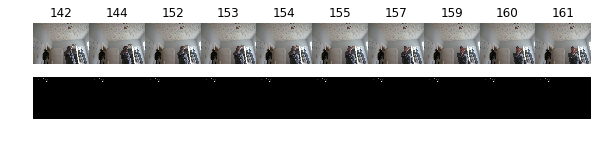

In [54]:
exploreImgs(listGS[:10], figw=10)

In [31]:
print 'length of %i' % len(df4[df4.checkTrackSuccess == False])
df4[df4.checkTrackSuccess == False][:4]

length of 28


,index,checkBaselineInsideTrack,checkBothContainsOther,checkEitherContainsOther,checkTrackInsideBaseline,checkTrackInsideBaselineRect,checkTrackSuccess,compareRadii,distanceFromBaseline
142,142,False,False,False,False,False,False,None,9999.9
144,144,False,False,False,False,False,False,None,9999.9
152,152,False,False,False,False,False,False,None,9999.9
153,153,False,False,False,False,False,False,None,9999.9


In [5]:
engine = sqlalchemy.create_engine('sqlite://', echo=True)

In [6]:
engine2 = sqlalchemy.create_engine('sqlite:///tmp.db', echo=True)

In [9]:
df.to_sql('myname', con=engine2 )

2018-12-28 18:26:56,349 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2018-12-28 18:26:56,351 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:26:56,355 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2018-12-28 18:26:56,357 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:26:56,358 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("myname")
2018-12-28 18:26:56,361 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:26:56,369 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE myname (
	"index" BIGINT, 
	"checkBaselineInsideTrack" BOOLEAN, 
	"checkBothContainsOther" BOOLEAN, 
	"checkEitherContainsOther" BOOLEAN, 
	"checkTrackInsideBaseline" BOOLEAN, 
	"checkTrackInsideBaselineRect" BOOLEAN, 
	"checkTrackSuccess" BOOLEAN, 
	"compareRadii" BIGINT, 
	"distanceFromBaseline" FLOAT, 
	"frameCounter" BIGINT, 
	"listIndex" BIGINT, 
	CHECK ("checkBaselineInsideTrack" IN (0, 1)), 
	CHECK ("check

In [10]:
engine3 = sqlalchemy.create_engine('sqlite:///tmp.db', echo=True)

In [12]:
newdf = pd.read_sql_table('myname', con=engine3)

2018-12-28 18:29:21,338 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2018-12-28 18:29:21,339 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:29:21,342 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2018-12-28 18:29:21,342 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:29:21,345 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2018-12-28 18:29:21,349 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:29:21,357 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='view' ORDER BY name
2018-12-28 18:29:21,358 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:29:21,361 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("myname")
2018-12-28 18:29:21,362 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:29:21,369 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SEL

In [13]:
newdf

,index,checkBaselineInsideTrack,checkBothContainsOther,checkEitherContainsOther,checkTrackInsideBaseline,checkTrackInsideBaselineRect,checkTrackSuccess,compareRadii,distanceFromBaseline,frameCounter,listIndex
0,0,True,True,True,True,False,True,6,2.236068,0,0
1,1,True,True,True,True,False,True,7,7.211103,9,1
2,2,True,True,True,True,False,True,-1,1.414214,78,2
3,3,True,True,True,True,False,True,3,4.472136,116,3
4,4,True,True,True,True,False,True,2,4.123106,136,4
5,5,True,True,True,True,False,True,0,5.385165,176,5
6,6,False,False,False,False,False,True,-1,5.385165,187,6
7,7,False,False,False,False,False,True,-2,6.000000,194,7
8,8,False,False,False,False,False,True,-1,4.000000,195,8
9,9,False,False,False,False,False,True,-3,4.123106,201,9


In [ ]:
DBInterface

In [7]:
db_name = "../data/misc/books/eval-data-2/large_dataset.db"
db = DBInterface(db_name)
listGS = [ pickle.loads(d[1]) for d in db.selectAll()]
tracker = TrackFactory(on=True)
tracker.setInit(ballColor = "orange")
tracker.setAlgoEnum(1)
evData = EvalDataset()
evData.buildDataset(listGS, tracker)
df = evData.getDataset()